# *Traffic Sign Recognizer - GTSRB Dataset*

## Importing Required Libraries

In [60]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

## Assigning Path for Dataset

In [1]:
train_path = 'train_images/GTSRB/Final_Training/Images'
test_path = 'test_images'
data_dir = test_path

# Resizing the images to 32x32x3
IMG_HEIGHT = 32
IMG_WIDTH = 32
channels = 3

## Finding Total Classes

In [3]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [8]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Visualizing The Dataset

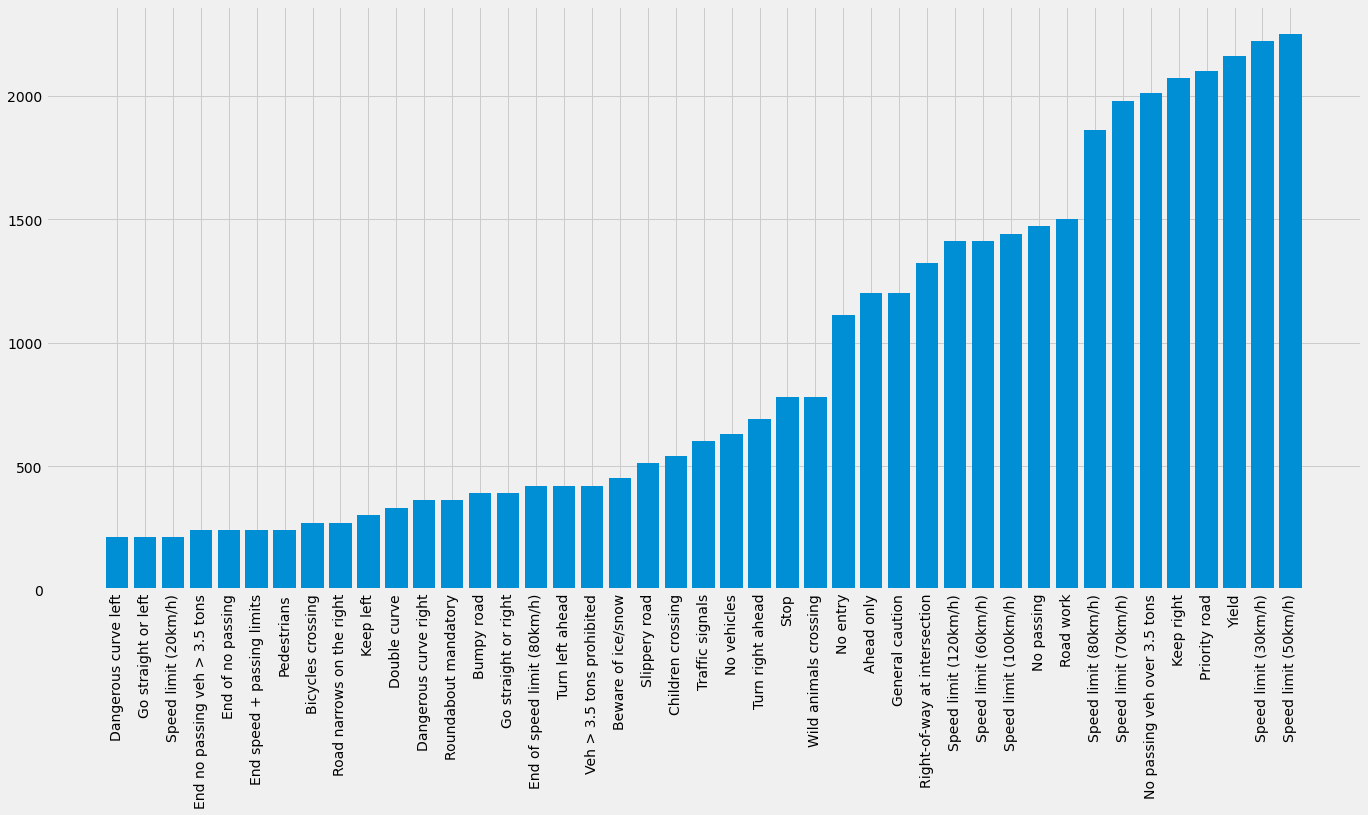

In [5]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

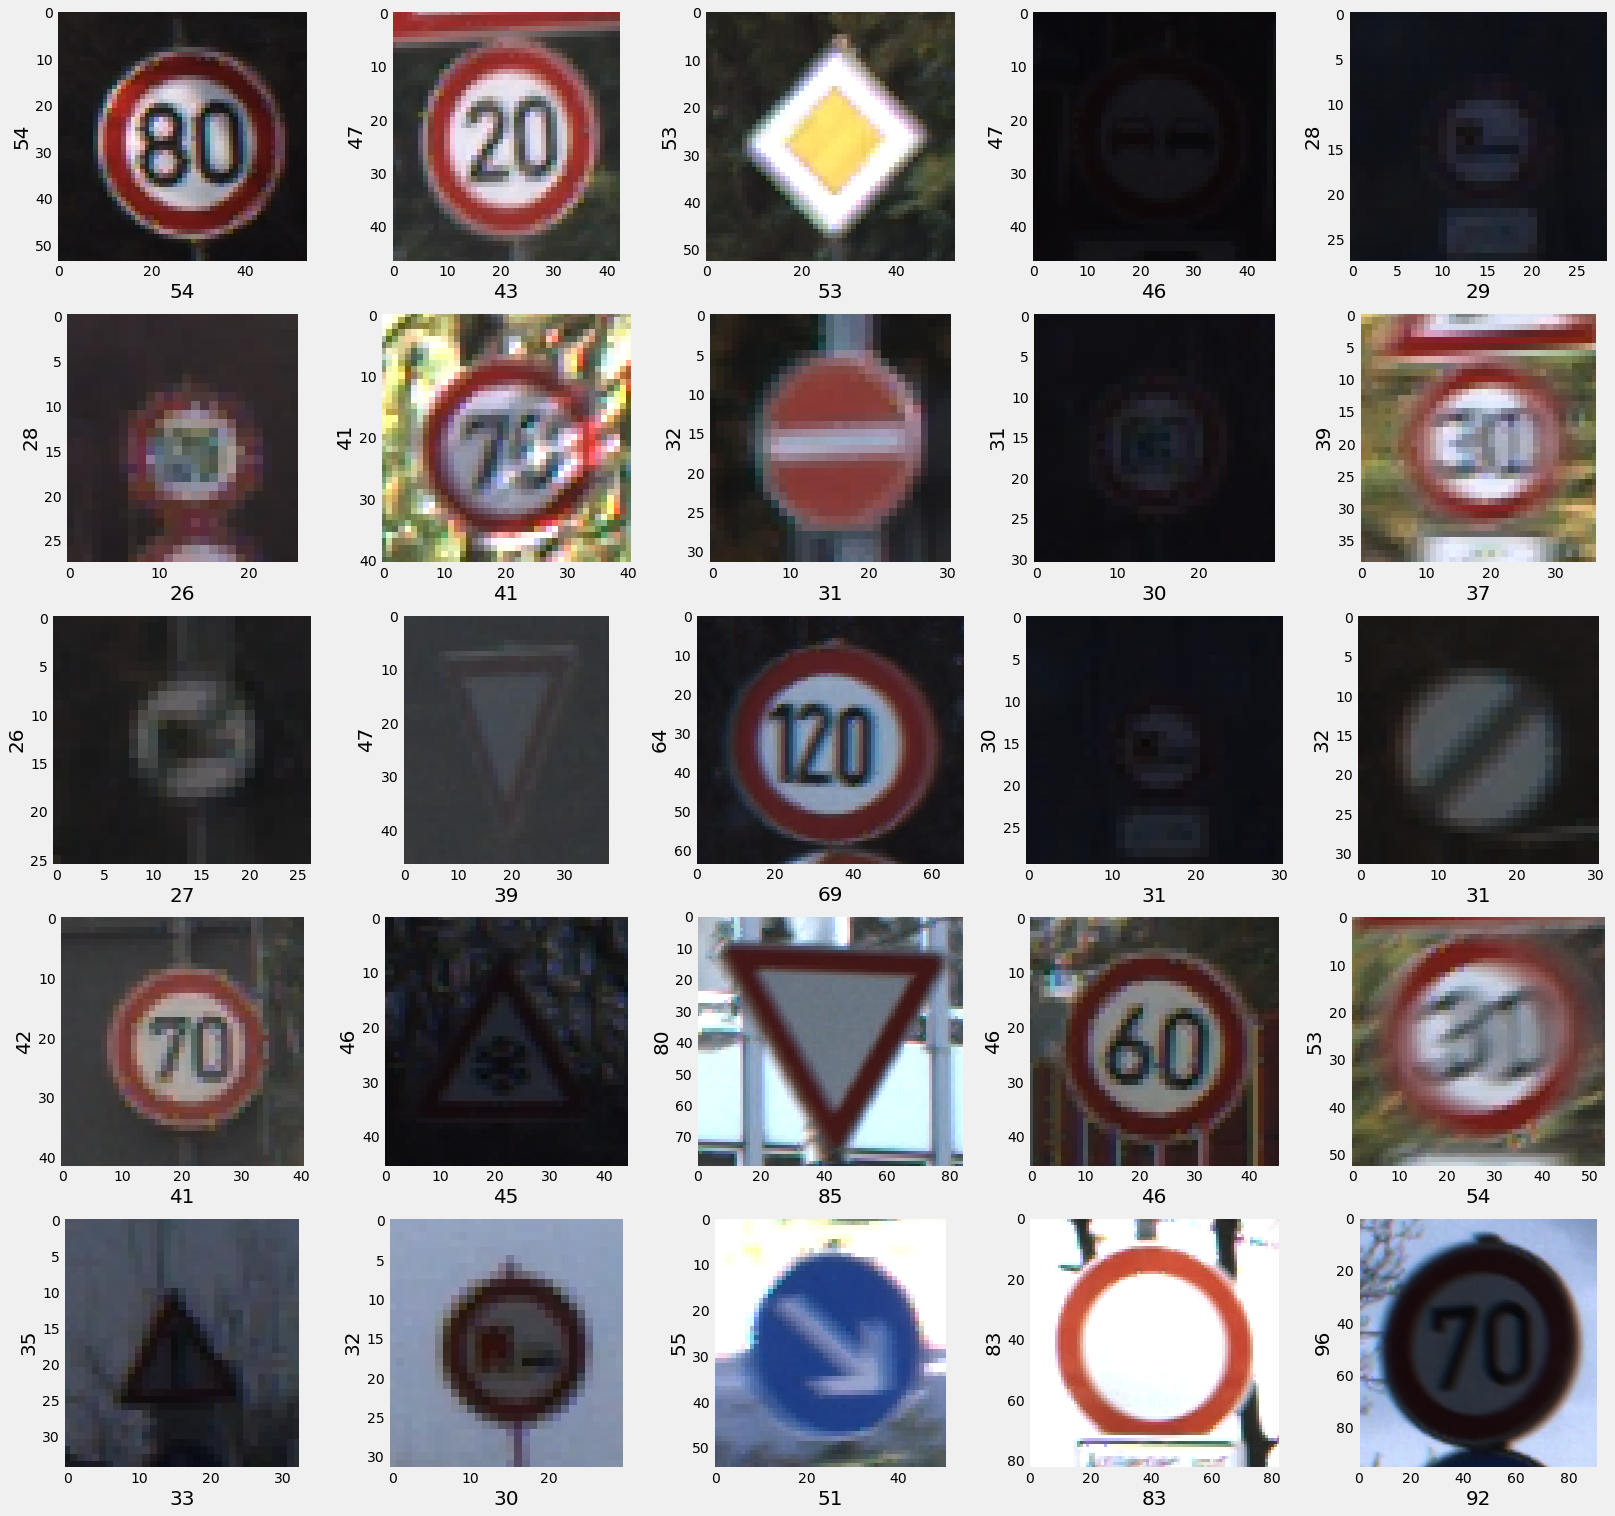

In [6]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

folders = os.listdir(test_path)

data =[]
imgs = []
for folder in folders:
    test_files = os.listdir(test_path + '/' + folder)
    for img in test_files:
        imgs.append('/' + folder + '/' + img)

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(visible=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

## Collecting the Training Data

In [9]:
image_data = []
image_labels = []

folders = os.listdir(train_path)

i=0
for folder in folders:
    path = train_path + '/' + folder
    images = os.listdir(path)

    for img in images:
        if(os.path.splitext(img)[1] != ".csv"):
            try:
                image = cv2.imread(path + '/' + img)
                image_fromarray = Image.fromarray(image, 'RGB')
                resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
                image_data.append(np.array(resize_image))
                image_labels.append(i)
            except:
                print("Error in " + img)
    i+=1
    
# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 32, 32, 3) (39209,)


## Shuffling the training data

In [10]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into train and validation set

In [11]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.2, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (31367, 32, 32, 3)
X_valid.shape (7842, 32, 32, 3)
y_train.shape (31367,)
y_valid.shape (7842,)


## One hot encoding the labels

In [12]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(31367, 43)
(7842, 43)


## Making the model

## Setting model save file path and early stopper

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

save_model_file_path = 'traffic_best_model/cp.ckpt'
checkpointerCB = ModelCheckpoint(filepath=save_model_file_path,
                                monitor= 'accuracy',
                                verbose=1,
                                save_weights_only=True,
                                save_best_only=True)

earlyStopperCB = EarlyStopping(monitor= 'accuracy', min_delta=0.00001, patience=9, verbose=1)

reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.000000001, verbose = 1)

#tsCallBackS = TensorBoard(log_dir='logA', histogram_freq=0, write_graph=True, write_images=True)

In [13]:
def create_alpha_CNN_model():
    model = keras.models.Sequential([    
        keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
        keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.BatchNormalization(axis=-1),
        
        keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.BatchNormalization(axis=-1),
        
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(rate=0.5),
        
        keras.layers.Dense(43, activation='softmax')
    ])
    return model
    
model_alpha = create_alpha_CNN_model()

In [18]:
from tensorflow.keras.layers import LeakyReLU

def create_beta_CNN_model():
    model = keras.models.Sequential([    
        keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation=LeakyReLU(alpha=0.01), input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
        keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation=LeakyReLU(alpha=0.01)),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.BatchNormalization(axis=-1),
        keras.layers.Dropout(rate=0.5),
        
        keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation=LeakyReLU(alpha=0.01)),
        keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation=LeakyReLU(alpha=0.01)),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.BatchNormalization(axis=-1),
        keras.layers.Dropout(rate=0.5),
        
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation=LeakyReLU(alpha=0.01)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(rate=0.5),
        
        keras.layers.Dense(43, activation='softmax')
    ])
    return model
    
model_beta = create_beta_CNN_model()

## Loading weigths from previous save file (optional)

In [ ]:
save_model_file_path9904fr = '/traffic_best_model9904fr/cp.ckpt'
modelLoad = create_alpha_CNN_model()
modelLoad.load_weights(save_model_file_path9904fr)

## Augmenting the data and training the model

In [17]:
from tensorflow.keras.optimizers import Adadelta

learning_rate = 0.001
epochs = 5

opt = Adam(learning_rate=learning_rate, decay=learning_rate / (epochs * 0.5))
#opt = Adadelta(learning_rate=learning_rate, rho=0.95, epsilon=1e-07, name="Adadelta")

model_alpha.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [51]:
from tensorflow.keras.optimizers import Adadelta

learning_rate = 0.001
epochs = 5

opt = Adam(learning_rate=learning_rate, decay=learning_rate / (epochs * 0.5))
#opt = Adadelta(learning_rate=learning_rate, rho=0.95, epsilon=1e-07, name="Adadelta")

model_beta.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [59]:
epochs = 50

aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model_beta.fit(aug.flow(X_train, y_train, batch_size=96), epochs=epochs, validation_data=(X_val, y_val), callbacks=[checkpointerCB, earlyStopperCB, reduceLR])

Epoch 1/50
327/327 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 0.9956
Epoch 00001: accuracy improved from -inf to 0.99560, saving model to C:/Users/fluids/Downloads/traffic_best_model\cp.ckpt
327/327 [==============================] - 12s 37ms/step - loss: 0.0140 - accuracy: 0.9956 - val_loss: 0.0010 - val_accuracy: 0.9997 - lr: 1.5625e-05
Epoch 2/50
327/327 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 0.99 - ETA: 0s - loss: 0.0118 - accuracy: 0.9962
Epoch 00002: accuracy improved from 0.99560 to 0.99621, saving model to C:/Users/fluids/Downloads/traffic_best_model\cp.ckpt
327/327 [==============================] - 12s 36ms/step - loss: 0.0118 - accuracy: 0.9962 - val_loss: 0.0010 - val_accuracy: 0.9997 - lr: 1.5625e-05
Epoch 3/50
327/327 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9960
Epoch 00003: accuracy did not improve from 0.99621
327/327 [==============================] - 12s 36ms/step - loss: 0.0134 

## Evaluating the model

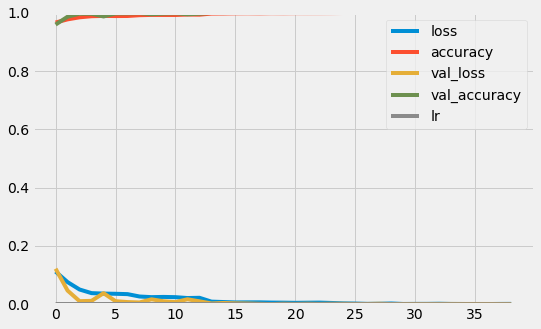

In [23]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Loading the test data and running the predictions

In [14]:
folders = os.listdir(test_path)

data =[]
labels = []

i = 0
for folder in folders:
    test_files = os.listdir(test_path + '/' + folder)
    for img in test_files:
        #print(test_path + '/' + folder + '/' + img)
        try:
            image = cv2.imread(test_path + '/' + folder + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            data.append(np.array(resize_image))
            labels.append(i)
        except Exception as e:
            print("Error in " + img , e)
    i+=1

X_test = np.array(data)
X_test = X_test/255

y_test = np.array(labels)
y_test = y_test/255

In [37]:
pred = np.argmax(model.predict(X_test),axis=1)

print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

Test Data accuracy:  99.10530482977039


## Save weights manually (if better accuracy)

In [25]:
# Save the weights using the `checkpoint_path` format
model.save_weights(save_model_file_path.format(epoch=0))

## SAVE MODEL

In [61]:
model_alpha_save_file_path = "traffic_saved_models/model_alpha_1.hdf5"
model_beta_save_file_path = "traffic_saved_models/model_beta_1.hdf5"

In [62]:
model_beta.save(model_beta_save_file_path)

## LOAD MODEL

In [63]:
model_beta_1 = tf.keras.models.load_model("traffic_saved_models_GA/model_beta_1.hdf5")

## GENETIC ALGORITHM

In [15]:
def model_acc_score(model):
    pred = np.argmax(model.predict(X_test),axis=1)
    return (accuracy_score(labels, pred)*100)

In [79]:
def genetic_algorithm_tecnique(model, epochs = 1, GA_cycle= 5, learning_rate = 0.0001, model_save_path = ""):
    print(model_save_path)
    model = tf.keras.models.load_model(model_save_path)
    for i in range(0, GA_cycle):
        cur_model_acc = model_acc_score(model)
        print("Current model accuracy:", cur_model_acc)

        aug = ImageDataGenerator(
            rotation_range=10,
            zoom_range=0.15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.15,
            horizontal_flip=False,
            vertical_flip=False,
            fill_mode="nearest")

        history = model.fit(aug.flow(X_train, y_train, batch_size=62), epochs=epochs, validation_data=(X_val, y_val))

        model_acc_after_fit = model_acc_score(model)
        if(cur_model_acc>model_acc_after_fit):
            model = tf.keras.models.load_model(model_save_path)
            print("Reloading Previous Model.")
        else:
            model.save(model_save_path)
            print("Saving Model.")

        print("Iteration:",i ," Model accuracy before fit:", cur_model_acc," Model accuracy after fit:", model_acc_after_fit)


In [66]:
model_beta_1 = tf.keras.models.load_model("traffic_saved_models_GA/model_beta_1.hdf5")

In [70]:
genetic_algorithm_tecnique(model_beta_1, model_save_path = "traffic_saved_models_GA/model_beta_1.hdf5")

C:/Users/fluids/Downloads/traffic_saved_models_GA/model_beta_1.hdf5
Current model accuracy: 98.90736342042756
506/506 [==============================] - 13s 25ms/step - loss: 0.0141 - accuracy: 0.9954 - val_loss: 0.0010 - val_accuracy: 0.9997
Reloading Previous Model.
Iteration: 0  Model accuracy before fit: 98.90736342042756  Model accuracy after fit: 98.89152810768013
Current model accuracy: 98.90736342042756
506/506 [==============================] - 12s 24ms/step - loss: 0.0145 - accuracy: 0.9954 - val_loss: 0.0010 - val_accuracy: 0.9997
Reloading Previous Model.
Iteration: 1  Model accuracy before fit: 98.90736342042756  Model accuracy after fit: 98.89152810768013
Current model accuracy: 98.90736342042756
506/506 [==============================] - 13s 24ms/step - loss: 0.0133 - accuracy: 0.9959 - val_loss: 0.0011 - val_accuracy: 0.9997
Reloading Previous Model.
Iteration: 2  Model accuracy before fit: 98.90736342042756  Model accuracy after fit: 98.89152810768013
Current model acc

## Visualizing the confusion matrix

In [23]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

<AxesSubplot:>

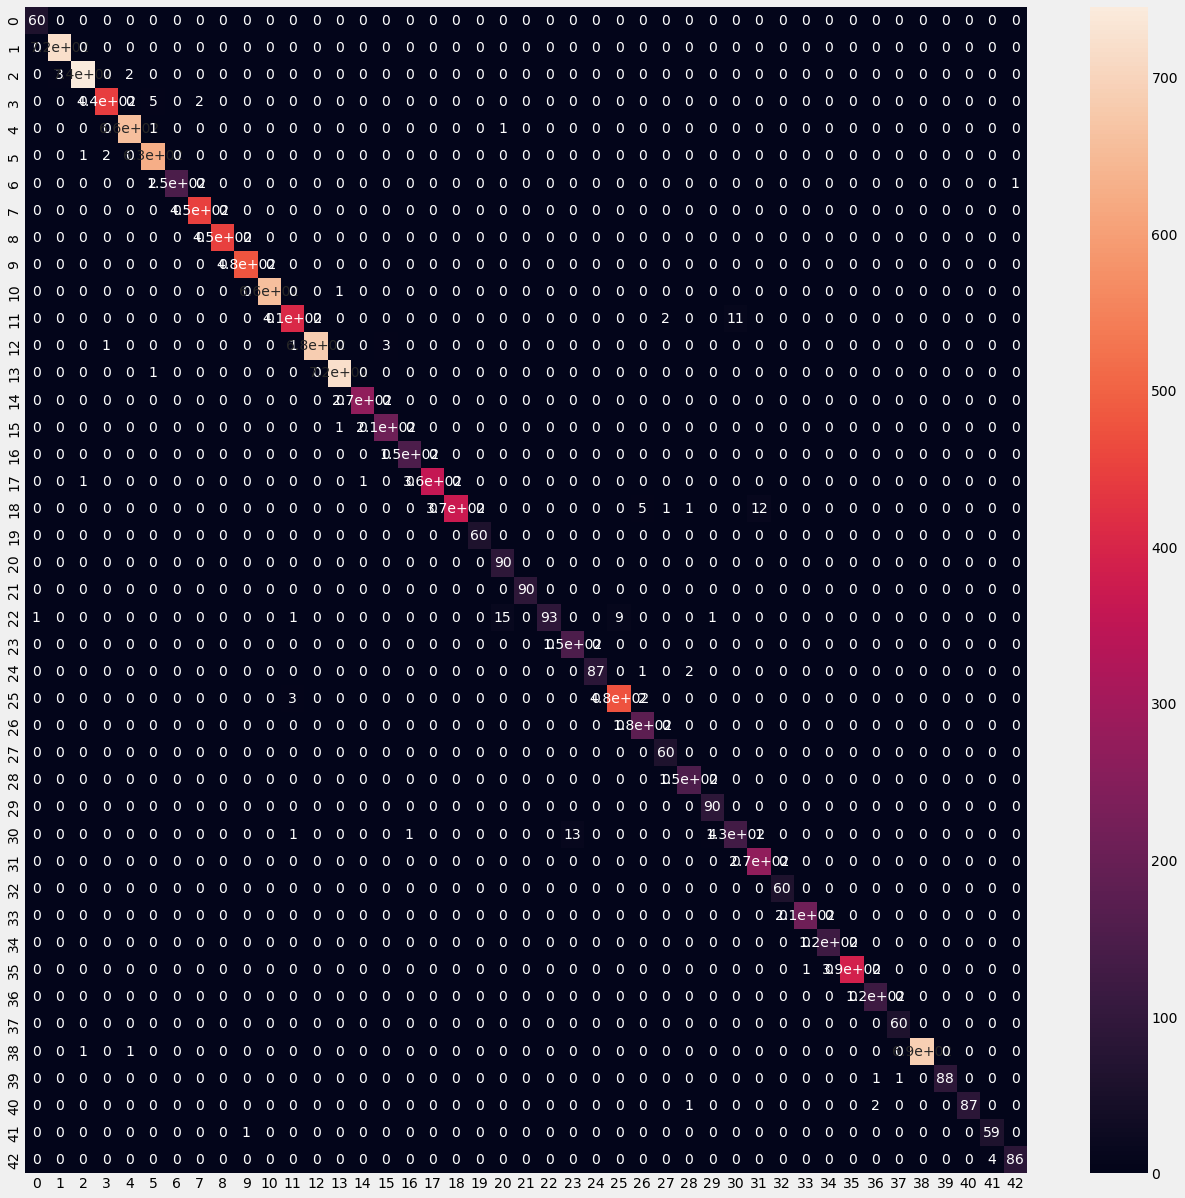

In [24]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

## Classification report

In [25]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       1.00      1.00      1.00       720
           2       1.00      0.99      0.99       750
           3       0.99      0.98      0.99       450
           4       1.00      1.00      1.00       660
           5       0.99      1.00      0.99       630
           6       1.00      0.98      0.99       150
           7       1.00      1.00      1.00       450
           8       1.00      1.00      1.00       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.99      0.97      0.98       420
          12       1.00      0.99      1.00       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.99      1.00      0.99       210
          16       0.99      1.00      1.00       150
          17       1.00    

## Predictions on Test Data

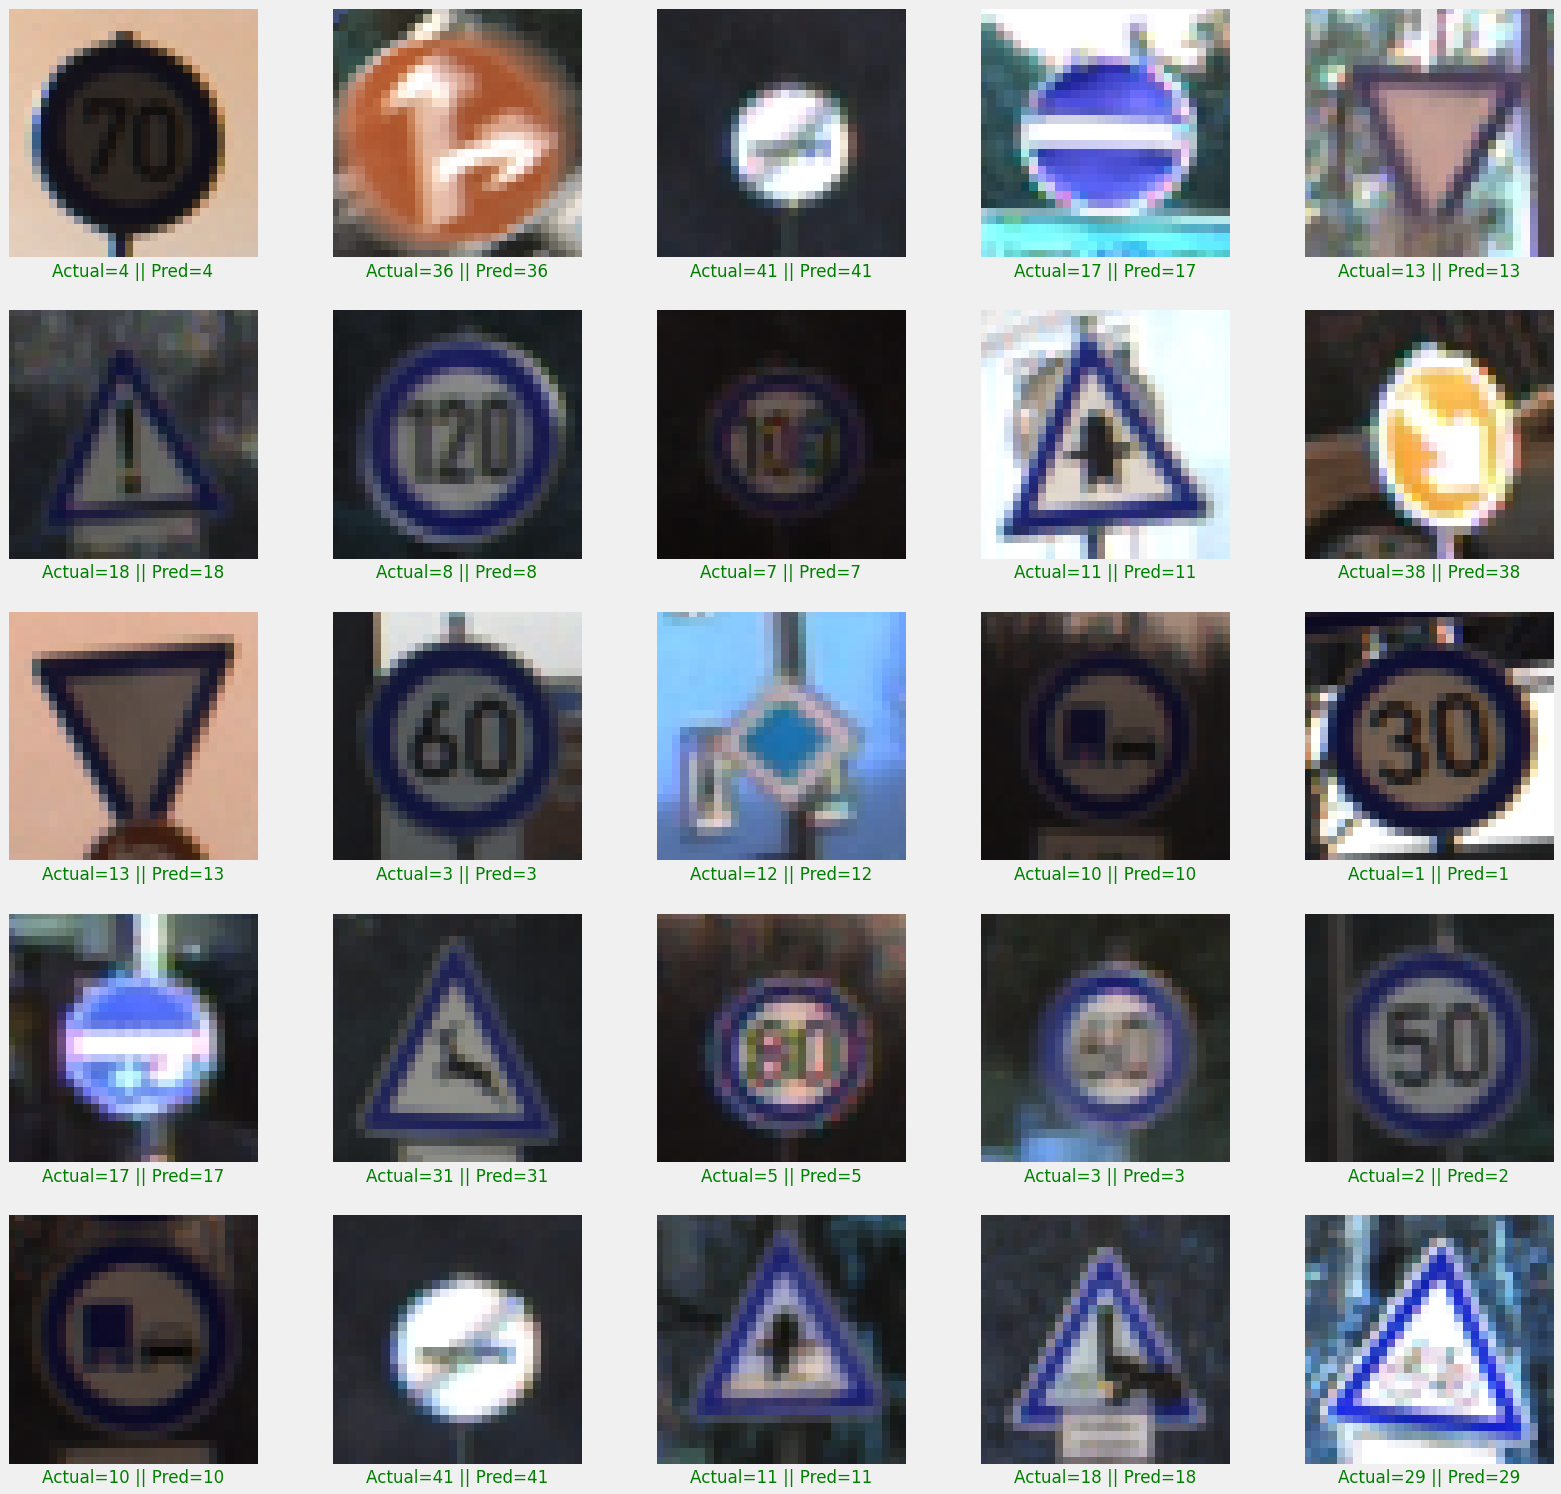

In [21]:
plt.figure(figsize = (25, 25))

start_index = 0

for i in range(0, 25):
    rng = random.randint(0, len(X_test))
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i + rng]
    actual = labels[start_index + i + rng]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i + rng])
plt.show()

# Version II - dynamic data augmentation

### Function to transform image

In [23]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

In [17]:
#https://www.tensorflow.org/api_docs/python/tf/image
#https://www.tensorflow.org/addons/api_docs/python/tfa/image

#pip install tensorflow-addons
import tensorflow_addons as tfa


def process_image(image, label):
    
    # random rotate 5 degrees
    r = tf.random.uniform(shape=(), minval=-0.175, maxval=0.175, dtype=tf.dtypes.float32)
    image = tfa.image.rotate(image, r)

    # translate image up to 10%
    rx = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32) 
    ry = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32) 
    image = tfa.image.translate(image, [rx, ry])
   
    # change hue, saturation and value
    image = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.2, 0.4, 1.1, 0.4, 1.1),0,1)

    return image, label

In [18]:
BATCH_SIZE = 64

dataV2 = dataset
dataV2 = dataV2.cache()
dataV2 = dataV2.shuffle(buffer_size = dataset.cardinality().numpy())
dataV2 = dataV2.map(process_image)
dataV2 = dataV2.prefetch(buffer_size=10200)
dataV2 = dataV2.batch(batch_size=BATCH_SIZE)
dataV2 = dataV2.repeat()

In [21]:
def prepare_callbacks(file_path):

    checkpointer = ModelCheckpoint(filepath= file_path, 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_weights_only=True,
                               save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience = 15, verbose = 1)

    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000000001, verbose = 1)

    return [checkpointer, earlyStopper, reduceLR]

In [75]:
model_alpha_V2 = tf.keras.models.load_model("traffic_saved_models_GA/model_alpha_V2.hdf5")

In [76]:
learning_rate = 0.0001
epochs = 5

opt = Adam(learning_rate=learning_rate, decay=learning_rate / (epochs * 0.5))
#opt = Adadelta(learning_rate=learning_rate, rho=0.95, epsilon=1e-07, name="Adadelta")

model_alpha_V2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

file_pathV2 = 'DA_modelV2/cp.ckpt'

callbacksV2 = prepare_callbacks(file_pathV2)

In [78]:
historyV2 = model_alpha_V2.fit(dataV2, steps_per_epoch = 10200/BATCH_SIZE,
          epochs=50, 
          validation_data=(X_val, y_val), 
          callbacks = callbacksV2)

Epoch 1/50
158/159 [============================>.] - ETA: 0s - loss: 0.0035 - accuracy: 0.9991
Epoch 00001: val_accuracy did not improve from 0.99987
159/159 [==============================] - 4s 27ms/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 0.0011 - val_accuracy: 0.9999 - lr: 1.0000e-04
Epoch 2/50
159/159 [============================>.] - ETA: 0s - loss: 0.0058 - accuracy: 0.9988
Epoch 00002: val_accuracy did not improve from 0.99987
159/159 [==============================] - 3s 21ms/step - loss: 0.0058 - accuracy: 0.9987 - val_loss: 0.0014 - val_accuracy: 0.9996 - lr: 1.0000e-04
Epoch 3/50
159/159 [============================>.] - ETA: 0s - loss: 0.0036 - accuracy: 0.9985
Epoch 00003: val_accuracy did not improve from 0.99987
159/159 [==============================] - 3s 22ms/step - loss: 0.0036 - accuracy: 0.9985 - val_loss: 0.0013 - val_accuracy: 0.9996 - lr: 1.0000e-04
Epoch 4/50
158/159 [============================>.] - ETA: 0s - loss: 0.0020 - accuracy: 0.9991
Epoc

In [84]:
def genetic_algorithm_tecnique_V2(model, epochs = 1, GA_cycle= 5, learning_rate = 0.0001, model_save_path = ""):
    print(model_save_path)
    model = tf.keras.models.load_model(model_save_path)
    
    for i in range(0, GA_cycle):
        cur_model_acc = model_acc_score(model)
        print("Current model accuracy:", cur_model_acc)

        BATCH_SIZE = 64

        dataV2 = dataset
        dataV2 = dataV2.cache()
        dataV2 = dataV2.shuffle(buffer_size = dataset.cardinality().numpy())
        dataV2 = dataV2.map(process_image)
        dataV2 = dataV2.prefetch(buffer_size=10200)
        dataV2 = dataV2.batch(batch_size=BATCH_SIZE)
        dataV2 = dataV2.repeat()

        historyV2 = model_alpha_V2.fit(dataV2, steps_per_epoch = 10200/BATCH_SIZE,
          epochs=epochs, 
          validation_data=(X_val, y_val), 
          callbacks = callbacksV2)

        model_acc_after_fit = model_acc_score(model)
        if(cur_model_acc>model_acc_after_fit):
            model = tf.keras.models.load_model(model_save_path)
            print("Reloading Previous Model.")
        else:
            model.save(model_save_path)
            print("Saving Model.")

        print("Iteration:",i ," Model accuracy before fit:", cur_model_acc," Model accuracy after fit:", model_acc_after_fit)

In [85]:
genetic_algorithm_tecnique_V2(model_alpha_V2, epochs = 1, GA_cycle= 5, model_save_path = "traffic_saved_models_GA/model_alpha_V2.hdf5")

C:/Users/fluids/Downloads/traffic_saved_models_GA/model_alpha_V2.hdf5
Current model accuracy: 99.20031670625495
159/159 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 0.9995
Epoch 00001: val_accuracy did not improve from 0.99987
159/159 [==============================] - 4s 27ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 5.1842e-04 - val_accuracy: 0.9999 - lr: 6.2500e-06
Saving Model.
Iteration: 0  Model accuracy before fit: 99.20031670625495  Model accuracy after fit: 99.20031670625495
Current model accuracy: 99.20031670625495
159/159 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 0.9997 ETA: 0s - loss: 0.0015 - accuracy: 0.99
Epoch 00001: val_accuracy did not improve from 0.99987
159/159 [==============================] - 4s 27ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 5.0252e-04 - val_accuracy: 0.9999 - lr: 6.2500e-06
Saving Model.
Iteration: 1  Model accuracy before fit: 99.20031670625495  Model accuracy after fit: 99

# Version III - Massive data augmentation

### Data augmentation functions

In [25]:
import tensorflow_addons as tfa
from PIL import Image, ImageFilter

def process_brightness(image, label):
    
    img = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 1.0, 1.0, 0.1, 3.0),0,1)
    return img, label

def process_saturation(image, label):
    
    img = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 1.0, 3.0, 1.0, 1.0),0,1)
    return img, label

def process_contrast(image, label):
    
    img = tf.clip_by_value(tf.image.random_contrast(image, lower=0.1, upper=3.0, seed=None), 0, 1)
    return img, label

def process_hue(image, label):
    
    img = tf.image.random_hue(image, max_delta=0.2, seed=None)
    return img, label

def process_rotate(image, label):
    
    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    return img, label

def process_shear(image, label):
    
    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    sx = tf.random.uniform(shape=(), minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32)
    img = tfa.image.transform(img, [1, sx, -sx*32,   0,1,0,  0,0])
    return img, label

def process_translate(image, label):

    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    tx = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)
    ty = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)  
    img = tfa.image.translate(img, [tx,ty])
    return img, label

def process_crop(image, label):
    
    c = tf.random.uniform(shape=(), minval=24, maxval=32, dtype=tf.dtypes.float32)
    img = tf.image.random_crop(image, size=[c,c,3])
    img = tf.image.resize(img ,size= [32,32])
    return img, label

def gaussian_blur(image, label):
    img = image.filter(ImageFilter.GaussianBlur(5))
    return img, label

def box_blur(image, label):
    img = image.filter(ImageFilter.BoxBlur(5))
    return img, label


In [26]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

dataV3 = dataset
# color ops
dataV3 = dataV3.map(process_brightness)
dataV3 = dataV3.concatenate(dataset.map(process_contrast))
dataV3 = dataV3.concatenate(dataset.map(process_hue))
dataV3 = dataV3.concatenate(dataset.map(process_saturation))

#geometry ops
dataV3 = dataV3.concatenate(dataset.map(process_rotate))
dataV3 = dataV3.concatenate(dataset.map(process_shear))
dataV3 = dataV3.concatenate(dataset.map(process_translate))
#dataV3 = dataV3.concatenate(dataset.map(process_crop))

dataV3 = dataV3.cache()
dataV3 = dataV3.shuffle(buffer_size = 81600)
dataV3 = dataV3.batch(batch_size = BATCH_SIZE)
dataV3 = dataV3.prefetch(buffer_size = AUTOTUNE)
dataV3 = dataV3.repeat()

In [19]:
model_alpha_V3 = tf.keras.models.load_model("traffic_saved_models_GA/model_alpha_V3.hdf5")

In [22]:
file_pathV3 = 'DA_modelV3/cp.ckpt'

callbacksV3 = prepare_callbacks(file_pathV3)

In [23]:
historyV3 = model_alpha_V3.fit(dataV3, steps_per_epoch = 81600/BATCH_SIZE,
          epochs=5, 
          validation_data = (X_val, y_val), 
          callbacks = callbacksV3)

Epoch 1/5
1275/1275 [==============================] - ETA: 0s - loss: 0.0793 - accuracy: 0.9819
Epoch 00001: val_accuracy improved from -inf to 0.99974, saving model to C:/Users/fluids/Downloads/DA_modelV3\cp.ckpt
1275/1275 [==============================] - 23s 11ms/step - loss: 0.0793 - accuracy: 0.9819 - val_loss: 0.0015 - val_accuracy: 0.9997 - lr: 3.1250e-05
Epoch 2/5
1269/1275 [============================>.] - ETA: 0s - loss: 0.0220 - accuracy: 0.9944
Epoch 00002: val_accuracy did not improve from 0.99974
1275/1275 [==============================] - 23s 18ms/step - loss: 0.0220 - accuracy: 0.9944 - val_loss: 0.0012 - val_accuracy: 0.9997 - lr: 3.1250e-05
Epoch 3/5
1272/1275 [============================>.] - ETA: 0s - loss: 0.0295 - accuracy: 0.9921
Epoch 00003: val_accuracy did not improve from 0.99974
1275/1275 [==============================] - 12s 9ms/step - loss: 0.0296 - accuracy: 0.9921 - val_loss: 0.0013 - val_accuracy: 0.9997 - lr: 3.1250e-05
Epoch 4/5
1271/1275 [=====

In [32]:
def genetic_algorithm_tecnique_V3(model, epochs = 1, GA_cycle= 5, learning_rate = 0.0001, model_save_path = ""):
    print(model_save_path)
    model = tf.keras.models.load_model(model_save_path)
    for i in range(0, GA_cycle):
        cur_model_acc = model_acc_score(model)
        print("Current model accuracy:", cur_model_acc)

        historyV3 = model.fit(dataV3, steps_per_epoch = 81600/BATCH_SIZE,
          epochs=epochs, 
          validation_data = (X_val, y_val), 
          callbacks = callbacksV3)

        model_acc_after_fit = model_acc_score(model)
        if(cur_model_acc>model_acc_after_fit):
            model = tf.keras.models.load_model(model_save_path)
            print("Reloading Previous Model.")
        else:
            model.save(model_save_path)
            print("Saving Model.")

        print("Iteration: ",i ," Model accuracy before fit:", cur_model_acc," Model accuracy after fit:", model_acc_after_fit)

In [33]:
genetic_algorithm_tecnique_V3(model_alpha_V3, epochs = 3, GA_cycle= 9, learning_rate = 0.00001, model_save_path = "traffic_saved_models_GA/model_alpha_V3.hdf5")

C:/Users/fluids/Downloads/traffic_saved_models_GA/model_alpha_V3.hdf5
Current model accuracy: 99.46159936658749
Epoch 1/3
1272/1275 [============================>.] - ETA: 0s - loss: 0.0264 - accuracy: 0.9921
Epoch 00001: val_accuracy did not improve from 0.99987
1275/1275 [==============================] - 13s 10ms/step - loss: 0.0264 - accuracy: 0.9921 - val_loss: 0.0011 - val_accuracy: 0.9997 - lr: 3.1250e-05
Epoch 2/3
1271/1275 [============================>.] - ETA: 0s - loss: 0.0112 - accuracy: 0.9966
Epoch 00002: val_accuracy did not improve from 0.99987
1275/1275 [==============================] - 11s 9ms/step - loss: 0.0112 - accuracy: 0.9966 - val_loss: 0.0011 - val_accuracy: 0.9997 - lr: 3.1250e-05
Epoch 3/3
1274/1275 [============================>.] - ETA: 0s - loss: 0.0152 - accuracy: 0.9956
Epoch 00003: val_accuracy did not improve from 0.99987
1275/1275 [==============================] - 12s 9ms/step - loss: 0.0152 - accuracy: 0.9956 - val_loss: 0.0011 - val_accuracy: 0.

## PREPARE ENSEMBLE

In [52]:
def prepare_callbacks(file_path):

    checkpointer = ModelCheckpoint(filepath= file_path, 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_weights_only=True,
                               save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience = 15, verbose = 1)

    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000000001, verbose = 1)

    return [checkpointer, earlyStopper, reduceLR]

In [58]:
NUM_MODELS = 6
NUM_CLASSES = NUM_CATEGORIES
IMAGE_SIZE = 32

def train_models(train, val, epochs, model_save_path, file_path_prefix, train_online=True):

    models = []
    histories = []
    
    for i in range(NUM_MODELS):

        model = tf.keras.models.load_model(model_save_path)

        if train_online:
            callbacks = prepare_callbacks(f'{file_path_prefix}_{i:02}/cp.ckpt')

            hist = model.fit(train,
                            steps_per_epoch = 81600/BATCH_SIZE,
                            epochs=epochs, 
                            validation_data = val, 
                            callbacks = callbacks)

        models.append(model)
        histories.append(hist)
    
    return models,histories

In [61]:
ensemble_models = train_models(dataV3, (X_val, y_val), epochs=5, model_save_path = "traffic_saved_models_GA/model_alpha_V3.hdf5", file_path_prefix = "emsemble/emsemble_model")

Epoch 1/5
1275/1275 [==============================] - ETA: 0s - loss: 0.0327 - accuracy: 0.9910
Epoch 00001: val_accuracy improved from -inf to 0.99962, saving model to C:/Users/fluids/Downloads/emsemble/emsemble_model_00\cp.ckpt
1275/1275 [==============================] - 19s 11ms/step - loss: 0.0327 - accuracy: 0.9910 - val_loss: 0.0012 - val_accuracy: 0.9996 - lr: 3.1250e-05
Epoch 2/5
1272/1275 [============================>.] - ETA: 0s - loss: 0.0123 - accuracy: 0.9965
Epoch 00002: val_accuracy did not improve from 0.99962
1275/1275 [==============================] - 23s 18ms/step - loss: 0.0123 - accuracy: 0.9965 - val_loss: 0.0011 - val_accuracy: 0.9996 - lr: 3.1250e-05
Epoch 3/5
1272/1275 [============================>.] - ETA: 0s - loss: 0.0193 - accuracy: 0.9943
Epoch 00003: val_accuracy improved from 0.99962 to 0.99974, saving model to C:/Users/fluids/Downloads/emsemble/emsemble_model_00\cp.ckpt
1275/1275 [==============================] - 12s 9ms/step - loss: 0.0193 - accu

In [26]:
testset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

## OPTIONAL

In [37]:
def load_weights(models, file_path_prefix):

    for i in range(NUM_MODELS):

        file_path = f'{file_path_prefix}_{i:02}/cp.ckpt'

        models[0][i].load_weights(file_path)
        models[0][i].save('temp.hdf5')

In [38]:
load_weights(ensemble_models, file_path_prefix = "emsemble/emsemble_model")

## EVALUATE

In [62]:
def evaluate_models(models):
    
    accuracy = 0

    for i in range(NUM_MODELS):

        eval = model_acc_score(models[0][i])
        accuracy += eval
        print(f'model {i} accuracy: {eval}')

    print(f'average accuracy: {(accuracy/NUM_MODELS):.3f}')    

In [63]:
evaluate_models(ensemble_models)

model 0 accuracy: 99.45368171021379
model 1 accuracy: 99.47743467933492
model 2 accuracy: 99.48535233570863
model 3 accuracy: 99.46159936658749
model 4 accuracy: 99.45368171021379
model 5 accuracy: 99.43784639746634
average accuracy: 99.462


In [69]:
preds = [ensemble_models[0][i].predict(X_test) for i in range(0, NUM_MODELS)]
preds = np.array(preds)
summed = np.sum(preds, axis = 0)

ensemble_prediction = np.argmax(summed, axis=1)
print(accuracy_score(labels, ensemble_prediction)*100)

99.45368171021379


## WEIGHTED AVERAGE ENSEMBLE

In [74]:
weights = [0.1, 0.1, 0.5, 0.1, 0.1, 0.1]
weighted_preds = np.tensordot(preds, weights, axes = ((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)
print(accuracy_score(labels, weighted_ensemble_prediction)*100)

99.46951702296121
